<a href="https://colab.research.google.com/github/suinkangme/COMP432-GroupI/blob/main/task1_training_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown --fuzzy 'https://drive.google.com/file/d/1625b8ZTvp0NdN8QoP4gFNfq0cTzWwO4x/view?usp=drive_link'
!gdown --fuzzy 'https://drive.google.com/file/d/1vJiQKoIrkr7fGYI5aZQN8TIhrGJwUjd_/view?usp=drive_link'
!gdown --fuzzy 'https://drive.google.com/file/d/1HJWoaKIw1v2ds-m8_E8Hjc_Bv5xtPW55/view?usp=drive_link'
!gdown --fuzzy 'https://drive.google.com/file/d/1sXYGPnAjUWBnOz55QqIOwb4Hh5Ljnt6i/view?usp=drive_link'


Downloading...
From: https://drive.google.com/uc?id=1625b8ZTvp0NdN8QoP4gFNfq0cTzWwO4x
To: /content/train_labels.npy
100% 38.5k/38.5k [00:00<00:00, 99.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vJiQKoIrkr7fGYI5aZQN8TIhrGJwUjd_
To: /content/test_images.npy
100% 723M/723M [00:04<00:00, 161MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HJWoaKIw1v2ds-m8_E8Hjc_Bv5xtPW55
To: /content/test_labels.npy
100% 9.73k/9.73k [00:00<00:00, 33.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sXYGPnAjUWBnOz55QqIOwb4Hh5Ljnt6i
To: /content/train_images.npy
100% 2.89G/2.89G [00:27<00:00, 106MB/s]


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import seaborn as sns

In [3]:
# Load the training and testing data
X_train = np.load('/content/train_images.npy')
y_train = np.load('/content/train_labels.npy')
X_test = np.load('/content/test_images.npy')
y_test = np.load('/content/test_labels.npy')

In [4]:
# Convert the data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

classes = ['MUS', 'NORM', 'STR']

In [5]:
# DataLoader for training and test data
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define ResNet-18 model with pre-trained weights
model = resnet18(weights = None)
num_classes = len(classes)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

In [6]:
# Set loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Training the model
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        batch_size= images.shape[0]
        h= images.shape[1]
        w= images.shape[2]
        channels= images.shape[3]
        images= torch.reshape(images,(batch_size,channels,h,w))
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print training loss and accuracy for each epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')


Epoch 1/20, Train Loss: 0.4852, Train Accuracy: 79.77%
Epoch 2/20, Train Loss: 0.4825, Train Accuracy: 79.79%
Epoch 3/20, Train Loss: 0.4958, Train Accuracy: 79.23%
Epoch 4/20, Train Loss: 0.4302, Train Accuracy: 81.79%
Epoch 5/20, Train Loss: 0.4311, Train Accuracy: 81.96%
Epoch 6/20, Train Loss: 0.4016, Train Accuracy: 83.75%
Epoch 7/20, Train Loss: 0.4288, Train Accuracy: 82.25%
Epoch 8/20, Train Loss: 0.4004, Train Accuracy: 83.79%
Epoch 9/20, Train Loss: 0.3707, Train Accuracy: 85.19%
Epoch 10/20, Train Loss: 0.3836, Train Accuracy: 85.31%
Epoch 11/20, Train Loss: 0.3670, Train Accuracy: 85.00%
Epoch 12/20, Train Loss: 0.3582, Train Accuracy: 85.85%
Epoch 13/20, Train Loss: 0.3460, Train Accuracy: 86.44%
Epoch 14/20, Train Loss: 0.3307, Train Accuracy: 86.73%
Epoch 15/20, Train Loss: 0.3265, Train Accuracy: 86.65%
Epoch 16/20, Train Loss: 0.3033, Train Accuracy: 88.44%
Epoch 17/20, Train Loss: 0.3122, Train Accuracy: 87.79%
Epoch 18/20, Train Loss: 0.3066, Train Accuracy: 88.38%
E

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/comp432/')

torch.save(model.state_dict(), '/content/drive/MyDrive/comp432/resnet18_model.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Note (During the training the model)

### Try 1
-> train accuracy 64.02% at Epoch 10/10.

number of epoch = 10,

batch size = 64,

optimizer = SGD(with regularization - weight_decay),


### Try 2 - change the optimizer to adam & remove regularization(weight decay) and dropout layer
-> train accuracy 77.92% at Epoch 10/10.

optimizer = adam(without regularization),


### Try 3 - train with more epoch
->  train accuracy 88.98% at Epoch 20/20.

number of epoch = 20




# **Testing**
*Notice : To run the tesing code below, you are required to this:
1. Run all the code above EXCEPT those cells where the model is trained and saved. This is to load the testing data.
2. Go download the saved model in our shared folder.
3. Upload the pth file. Do not make any directory.


In [7]:
state_dict = torch.load ('/content/resnet18_model.pth', map_location = torch.device('cpu'))
#in case you are curious what the weights look like ...
#print(state_dict)

In [8]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [9]:
from sklearn.metrics import classification_report
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
running_loss = 0
total = 0
correct = 0
y_pred = []
y_test = []
with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    batch_size= images.shape[0]
    h= images.shape[1]
    w= images.shape[2]
    channels= images.shape[3]
    images= torch.reshape(images,(batch_size,channels,h,w))
    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    y_pred.append(predicted)
    y_test.append(labels)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

y_pred_torch = torch.stack(y_pred[0:-1], dim=1)
y_test_torch = torch.stack(y_test[0:-1], dim=1)

y_pred_torch = y_pred_torch.cpu().detach().numpy()
y_test_torch = y_test_torch.cpu().detach().numpy()
target_names = ['MUS', 'NORM', 'STR']
y_pred_torch = np.reshape(y_pred_torch,(-1, 1))
y_test_torch = np.reshape(y_test_torch, (-1, 1))
print(classification_report(y_test_torch, y_pred_torch, target_names = target_names))
test_loss = running_loss / len(train_loader)
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')




              precision    recall  f1-score   support

         MUS       0.87      0.86      0.87       396
        NORM       0.87      0.96      0.91       370
         STR       0.84      0.76      0.80       386

    accuracy                           0.86      1152
   macro avg       0.86      0.86      0.86      1152
weighted avg       0.86      0.86      0.86      1152

Test Loss: 0.0894, Test Accuracy: 86.08%


In [12]:
#feature extraction
extracted_features = []
with torch.no_grad():
  for batch in train_loader:
    images, _ = batch
    images = images.to(device)
    batch_size= images.shape[0]
    h= images.shape[1]
    w= images.shape[2]
    channels= images.shape[3]
    images= torch.reshape(images,(batch_size,channels,h,w))
    features = model(images)
    features = features.view(features.size(0), -1)
    extracted_features.append(features.cpu().numpy())

# Concatenate all features to get the full feature set
extracted_features = np.concatenate(extracted_features, axis=0)

In [82]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state = 0)
tsne_result = tsne.fit_transform(extracted_features)

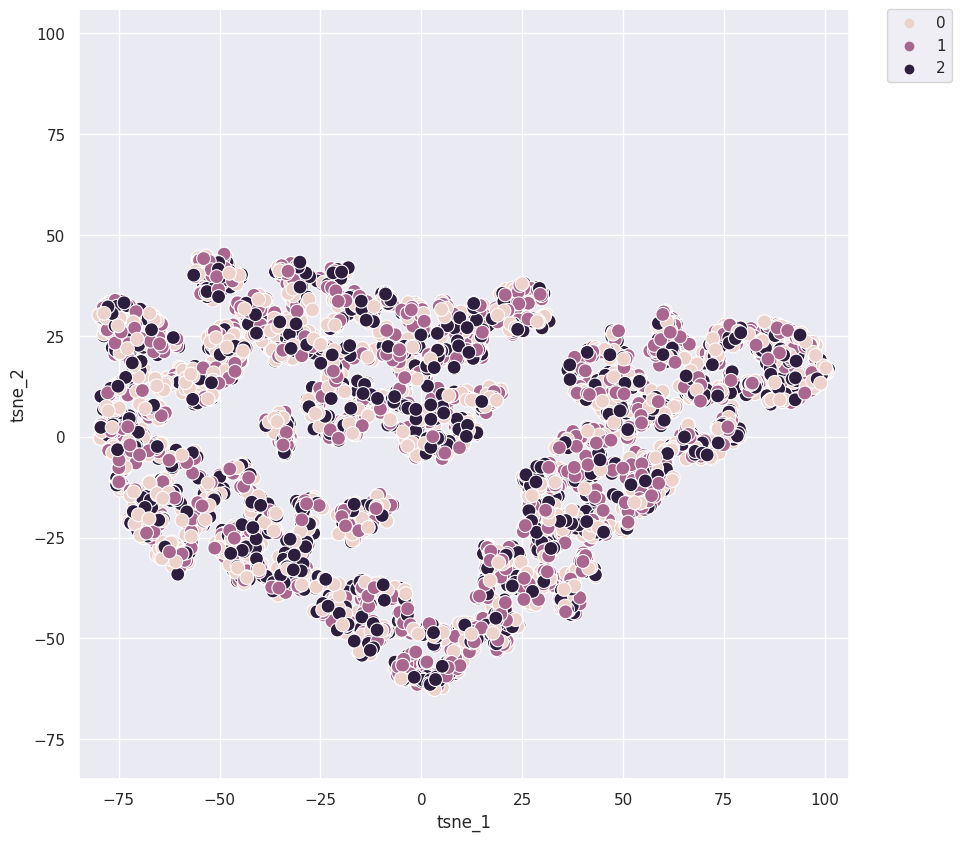

In [83]:
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y_train})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=100)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [40]:
tsne_3d = TSNE(n_components = 3, random_state = 0)
tsne_result_3d = tsne.fit_transform(extracted_features)


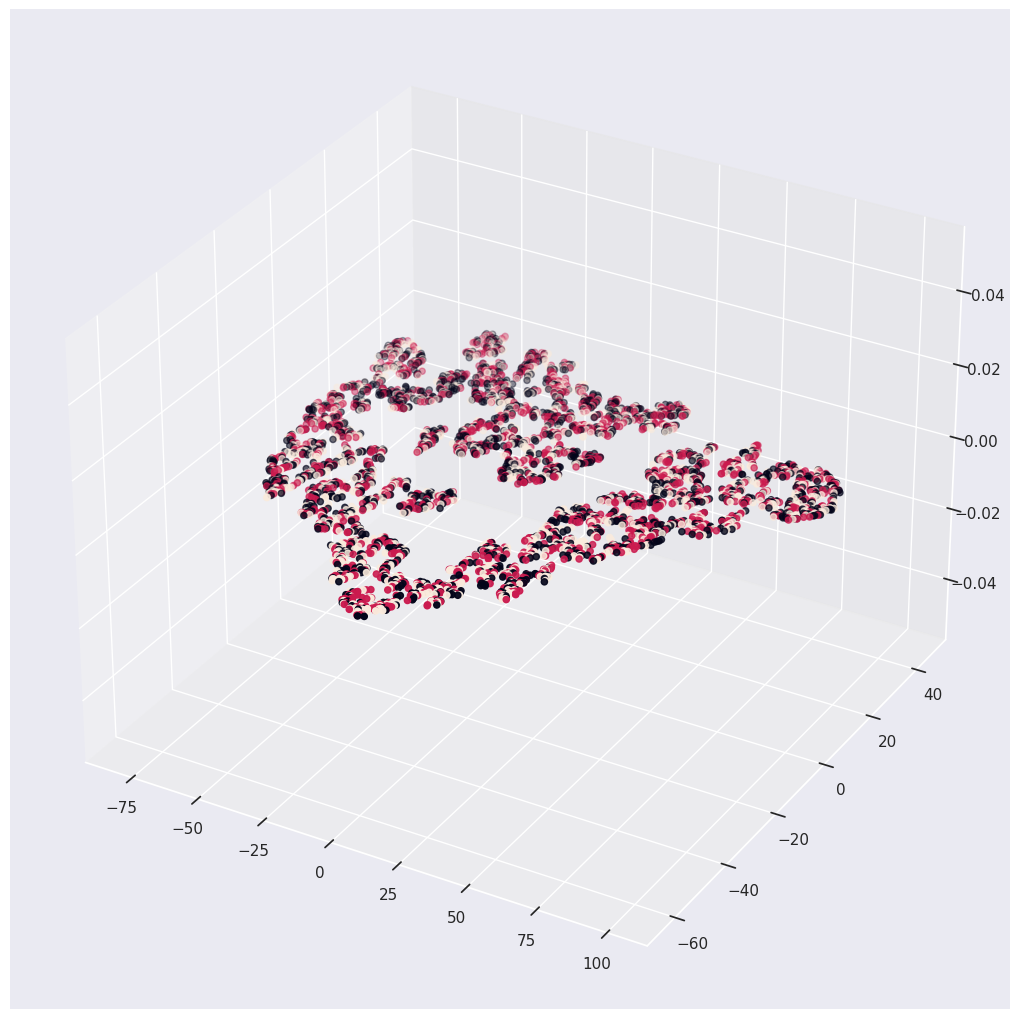

In [77]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
tsne_result_df_3d = pd.DataFrame({'tsne_1': tsne_result_3d[:,0], 'tsne_2': tsne_result_3d[:,1], 'label': y_train})
fig = plt.figure(figsize=(10,10))
axs = Axes3D(fig, auto_add_to_figure = False)
fig.add_axes(axs)
axs.scatter(xs = 'tsne_1', ys = 'tsne_2', data = tsne_result_df_3d, c = 'label' )